# Design Materials with optimal propertities

<div align="center">
  <b>Part 1: Background</b>
  
</div>


<div style="display: flex; justify-content: center;"> 
    <iframe src="_static/RL_AIMS.pdf" width="50%" height="300px"></iframe>
</div>

[Lecture slides](./_static/RL_AIMS.pdf)

<div align="center">
  <b>Part 2: Hands on</b>
</div>

### Hands on: Self-Driving Taxi with Reinforcement Tabular Q-Learning
This tutorial is updated and based on [here](https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/)

In [ ]:
#!pip install pygame
#!pip install cmake 'gym[atari]' scipy

The Smartcab's job is to pick up the passenger at one location and drop them off in another. Here are a few things that we'd love our Smartcab to take care of:

1. Drop off the passenger to the right location.
2. Save passenger's time by taking minimum time possible to drop off
3. Take care of passenger's safety and traffic rules

### A random start of state

array([[[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[114, 116, 115],
        [114, 116, 115],
        [126, 127, 126],
        ...,
        [112, 113, 111],
        [112, 113, 111],
        [118, 117, 115]],

       ...,

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[115, 112, 112],
        [115, 112, 112],
        [119, 119, 117],
        ...,
        [123, 119, 118],
        [123, 119, 118],
        [114, 114, 117]]], dtype=uint8)
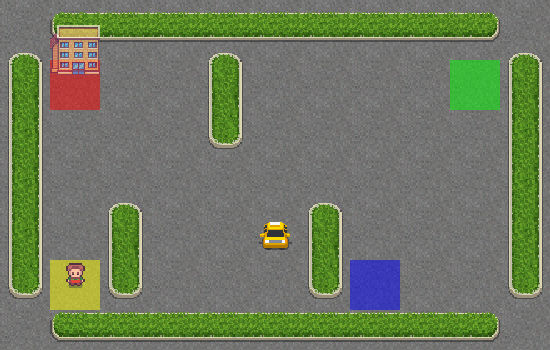

In [3]:
import gym
import numpy as np

# Initialize the Taxi-v3 environment
env = gym.make("Taxi-v3", render_mode="rgb_array")

env.reset()
env.render()

**Tips: Understanding the env.**

In [ ]:
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

Action Space Discrete(6)
State Space Discrete(500)


**1. Rewards**

Since the agent (the imaginary driver) is reward-motivated and is going to learn how to control the cab by trial experiences in the environment, we need to decide the rewards and/or penalties and their magnitude accordingly. Here a few points to consider:

i. The agent should receive a high positive reward for a successful dropoff because this behavior is highly desired

ii. The agent should be penalized if it tries to drop off a passenger in wrong locations

iii. The agent should get a slight negative reward for not making it to the destination after every time-step. "Slight" negative because we would prefer our agent to reach late instead of making wrong moves trying to reach to the destination as fast as possible

**2. State Space**

The State Space is the set of all possible situations our taxi could inhabit. The state should contain useful information the agent needs to make the right action.

Let's say we have a training area for our Smartcab where we are teaching it to transport people in a parking lot to four different locations (R, G, Y, B).

Let's assume Smartcab is the only vehicle in this parking lot. We can break up the parking lot into a 5x5 grid, which gives us 25 possible taxi locations. These 25 locations are one part of our state space. Notice the current location state of our taxi is coordinate (3, 1).

You'll also notice there are four (4) locations that we can pick up and drop off a passenger: R, G, Y, B or [(0,0), (0,4), (4,0), (4,3)] in (row, col) coordinates. Our illustrated passenger is in location Y and they wish to go to location R.

When we also account for one (1) additional passenger state of being inside the taxi, we can take all combinations of passenger locations and destination locations to come to a total number of states for our taxi environment; there's four (4) destinations and five (4 + 1) passenger locations.

So, our taxi environment has  **5 * 5 * 5 * 4 = 500**
 total possible states.


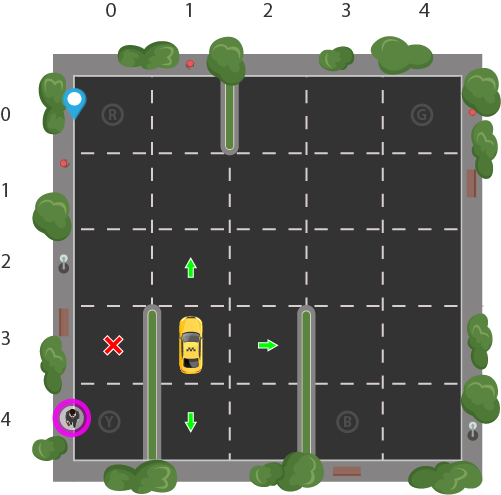

The agent encounters one of the 500 states and it takes an action. The action in our case can be to move in a direction or decide to pickup/dropoff a passenger. In other words, we have six possible actions:

 **0-south, 1-north, 2-east, 3-west, 4-pickup, 5-dropoff**

You'll notice in the illustration above, that the taxi cannot perform certain actions in certain states due to walls. In environment's code, we will simply provide a -1 penalty for every wall hit and the taxi won't move anywhere. This will just rack up penalties causing the taxi to consider going around the wall.

Tips: mannually set the state of the env

State: 328


array([[[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[114, 116, 115],
        [114, 116, 115],
        [126, 127, 126],
        ...,
        [112, 113, 111],
        [112, 113, 111],
        [118, 117, 115]],

       ...,

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[115, 112, 112],
        [115, 112, 112],
        [119, 119, 117],
        ...,
        [123, 119, 118],
        [123, 119, 118],
        [114, 114, 117]]], dtype=uint8)
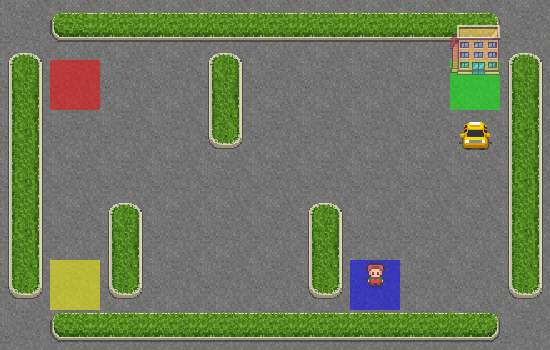

In [15]:
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
env.render()

Tips: look at the initial reward table

We can think of it like a matrix that has the number of states as rows and number of actions as columns, i.e. a **states * actions** matrix.

1. This dictionary has the structure {action: [(probability, nextstate, reward, done)]}.

2. Note that if our agent chose to explore action two (2) in this state it would be going East into a wall. The source code has made it impossible to actually move the taxi across a wall, so if the taxi chooses that action, it will just keep accruing -1 penalties, which affects the long-term reward.

In [ ]:
env.P[328] #Transition dynamics

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

### Without RL just random search

In [ ]:
env.s = 328  # set environment to illustration's state

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation

done = False

while not done:
    action = env.action_space.sample()
    state, reward, done, truncated, info = env.step(action)

    if reward == -10:
        penalties += 1
    frames.append({
        'frame': env.render(),
        'state': state,
        'action': action,
        'reward': reward
        }
    )
    epochs += 1

In [ ]:
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 4799
Penalties incurred: 1571


### With Reinforcement learning, we use Q-learning here

**Q-learning**

The values store in the Q-table are called a Q-values, and they map to a (state, action) combination.

If the taxi is faced with a state that includes a passenger at its current location, it is highly likely that the Q-value for **pickup** is higher when compared to other actions, like dropoff or north.

Q-values are initialized to an arbitrary value, and as the agent exposes itself to the environment and receives different rewards by executing different actions, the Q-values are updated using the equation:

**Q(state, action) = (1-alpha)Q(state, action) + alpha * (reward + gamma * (max) Q(nextstate, all actions)**


Where:

-
 (alpha) is the learning rate (0 < alpha <= 1)
) - Just like in supervised learning settings,
 is the extent to which our Q-values are being updated in every iteration.

-
 (gamma) is the discount factor (0 <= gamma <= 1
) - determines how much importance we want to give to future rewards. A high value for the discount factor (close to 1) captures the long-term effective award, whereas, a discount factor of 0 makes our agent consider only immediate reward, hence making it greedy.


**Q-Table**

The Q-table is a matrix where we have a row for every state (500) and a column for every action (6). It's first initialized to 0, and then values are updated after training. Note that the Q-table has the same dimensions as the reward table, but it has a completely different purpose.

Breaking it down into steps, we get

1. Initialize the Q-table by all zeros.
2. Start exploring actions: For each state, select any one among all possible actions for the current state (S).
3. Travel to the next state (S') as a result of that action (a).
4. For all possible actions from the state (S') select the one with the highest Q-value.
5. Update Q-table values using the equation.
6. Set the next state as the current state.

If goal state is reached, then end and repeat the process.

In [ ]:
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])
q_table

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

Exploiting learned values

After enough random exploration of actions, the Q-values tend to converge serving our agent as an action-value function which it can exploit to pick the most optimal action from a given state.

There's a tradeoff between exploration (choosing a random action) and exploitation (choosing actions based on already learned Q-values). We want to prevent the action from always taking the same route, and possibly overfitting, so we'll be introducing another parameter called
 **"epsilon"** to cater to this during training.

Instead of just selecting the best learned Q-value action, we'll sometimes favor exploring the action space further. Lower epsilon value results in episodes with more penalties (on average) which is obvious because we are exploring and making random decisions.

### **Implementing Q-learning**

### Train

In [ ]:
import gym
import numpy as np
from IPython.display import display, HTML
from PIL import Image
import matplotlib.pyplot as plt
import os

# Initialize the Taxi-v3 environment
env = gym.make("Taxi-v3", render_mode="rgb_array")  # Render as RGB images

# Define hyperparameters
alpha = 0.1       # Learning rate
gamma = 0.99      # Discount factor
epsilon = 1.0     # Exploration rate
epsilon_decay = 0.995
epsilon_min = 0.01
episodes = 5000
max_steps_per_episode = 100

# Initialize Q-table
state_space_size = env.observation_space.n
action_space_size = env.action_space.n
q_table = np.zeros((state_space_size, action_space_size))
for episode in range(episodes):
    state = env.reset()[0]
    done = False
    #total_reward = 0
    for step in range(max_steps_per_episode):
        #frame = env.render()  # Render the environment as an RGB array
        #frames.append(Image.fromarray(frame))  # Convert frame to an image
        action = np.argmax(q_table[state])

        # Perform the action
        next_state, reward, done, truncated, info = env.step(action)
        q_table[state, action] = q_table[state, action] + alpha * (
            reward + gamma * np.max(q_table[next_state]) - q_table[state, action]
        )
        state = next_state
        if done:
            break

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

print("Training complete.")

# # Save frames as a GIF with infinite looping
# gif_path = "taxi_v3_simulation.gif"
# frames[0].save(
#     gif_path, save_all=True, append_images=frames[1:], duration=300, loop=0
# )
# print(f"GIF saved at {gif_path}")

# # Display the GIF in the notebook with infinite looping
# from IPython.display import HTML
# display(HTML(f'<img src="{gif_path}" style="display:block;">'))


Training complete.


In [ ]:
## The q_table after 100 episodes training
q_table[328] #**0-south, 1-north, 2-east, 3-west, 4-pickup, 5-dropoff**

array([-0.48377292, -0.48674903, -0.5193675 , -0.499001  , -1.        ,
       -1.        ])

Answers: Go for "**south**" if we train the q-table with 100 episodes.

In [ ]:
## The q_table after 1000 episodes training
q_table[328]

array([-4.3915121 , -4.41222092, -4.47884251, -4.40240422, -4.99001   ,
       -4.99001   ])

In [ ]:
## The q_table after 5000 episodes training
q_table[328]

array([-4.83617676,  8.02075149, -4.7696461 , -4.7842214 , -4.99001   ,
       -4.99001   ])

### Test

Total reward per episode: 12.0
GIF saved at taxi_v3_simulation.gif


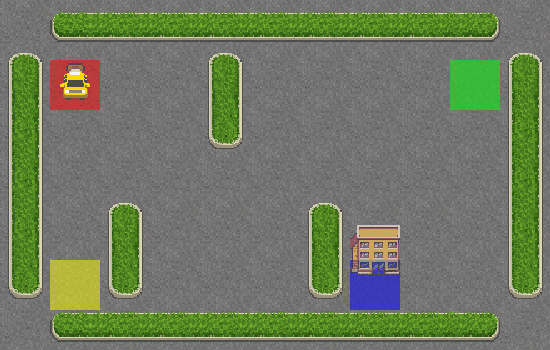

In [ ]:
# Testing the trained agent and rendering as GIF
frames = []  # Store frames for GIF
test_episodes = 1
for episode in range(test_episodes):
    state = env.reset()[0]
    done = False
    total_reward = 0
    for step in range(max_steps_per_episode):
        frame = env.render()  # Render the environment as an RGB array
        frames.append(Image.fromarray(frame))  # Convert frame to an image
        action = np.argmax(q_table[state])

        # Correctly unpack the result of env.step()
        next_state, reward, done, truncated, info = env.step(action)
        done = done or truncated  # Handle termination

        total_reward += reward
        state = next_state
        if done:
            break

print(f"Total reward per episode: {total_reward / test_episodes}")

env.close()

# Save frames as a GIF
gif_path = "taxi_v3_simulation.gif"
frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=300, loop=0)
print(f"GIF saved at {gif_path}")


# Display the GIF in the notebook
from IPython.display import Image as IPImage
display(IPImage(gif_path))

<div align="center">
  <b>Part 3: Homework</b>
</div>

### Reflection and improvement
Requirements on homework: finish the task and import the notebook as a **pdf** with your codes, plots, results and discussions. 
#### Task 1: **Hyperparameters and optimizations**

In [ ]:
# your code block

In [ ]:
# your comment block

#### Task 2: **switch to another policy training method**

In [ ]:
## Choose another policy learning algorithm to train the agent and compare the performance of two models. 

In [ ]:
## your comment block 

#### Task 3: 
Now change the agent to a thermoelectric material Bi2Te3, you can download the structure from [here](https://next-gen.materialsproject.org/materials/mp-541837?formula=Bi2Se3); you have the options to change Te into Se. 

In [ ]:
# Installation of libraries
!pip install optimade --quiet
!pip install matminer --quiet
!pip install elementembeddings --quiet
!pip install pymatviz --quiet 
!pip install plotly --quiet 

Database queries: Chemical space of thermoelectric materials
We can use [matminer](https://matminer.readthedocs.io/en/latest/) to access a dataset. Today we will turn to thermoelectric materials.

Thermoelectric devices convert temperature differences directly into electrical voltage, enabling applications in power generation and refrigeration. Their efficiency is characterised by the dimensionless figure of merit (zT), which depends on electrical conductivity, Seebeck coefficient, and thermal conductivity (read more here). Let's explore the diverse compositions that give rise to these properties.

In [ ]:
## code hint
import matminer  # Materials informatics
from matminer.datasets.dataset_retrieval import load_dataset  # Load materals datasets

print(matminer.datasets.dataset_retrieval.get_all_dataset_info('ucsb_thermoelectrics'))

For featurisation, we recommend using the [elementembeddings](https://wmd-group.github.io/ElementEmbeddings/stable/) library.

In [ ]:
## Code hint on composition featurization, in this task, we only care about the compositional features
from elementembeddings.composition import composition_featuriser

magpie_df = composition_featuriser(df, formula_column="composition", embedding='magpie')
magpie_df.head()

Now build your material env using gym
* action space: we only care about the compositional ratio of Te:Se from 0 to 1 with a step of 0.01
* reward function: you need to train a surrogate model based on the known database you have downloaded. 
* train the RL model

In [ ]:
## your code block

In [ ]:
## your comment block

#### Task 4(optional): if compositional features are not good enough, you may choose to incorporate the structural informaitons. 

In [ ]:
## your code block

In [ ]:
## your comment block